In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from statistics import mode
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import re
from xgboost import XGBClassifier
from google.colab import files
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.combine import SMOTEENN
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## **Upload Dataset**

In [3]:
#Uploading files 
uploaded = files.upload()

Saving fake_job_postings.csv to fake_job_postings.csv


In [4]:
#Reading CSV Files to Pandas Dataframe
df = pd.read_csv('fake_job_postings.csv')
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [ ]:
#Summarizing NAs
df.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

Text(0.5, 1.0, 'Classes Counts')

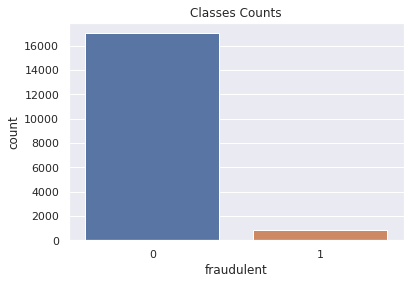

In [ ]:
#Visualizing Imbalanced Dataset
sns.set(style="darkgrid")
sns.countplot(x = "fraudulent" , data = df).set_title('Classes Counts')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


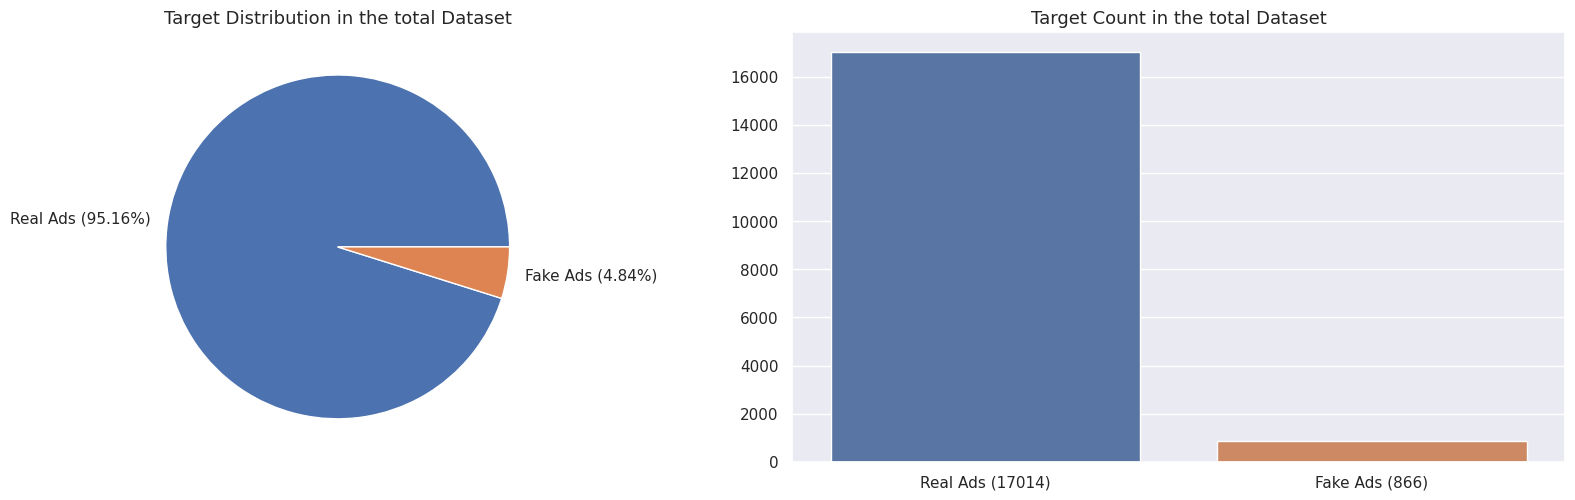

In [ ]:
#More Plots
fig, axes = plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
plt.tight_layout()

df["fraudulent"].value_counts().plot(kind='pie', ax=axes[0], labels=['Real Ads (95.16%)', 'Fake Ads (4.84%)'])
temp = df["fraudulent"].value_counts()
sns.barplot(temp.index, temp, ax=axes[1])

axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')
axes[1].set_xticklabels(["Real Ads (17014)", "Fake Ads (866)"])

axes[0].set_title('Target Distribution in the total Dataset', fontsize=13)
axes[1].set_title('Target Count in the total Dataset', fontsize=13)

plt.show()

## **Data Cleanning**

In [6]:
#Dealing with text missing data
df.update(df[['title','location','department','company_profile','description','requirements','benefits','employment_type','required_education','industry','function']].fillna(" "))
#Combining all text together
df['content'] = df['title'] + ' ' + df['location'] + ' ' + df['department'] + ' ' + df['company_profile'] + ' ' + df['description'] + ' ' + df['requirements'] + ' ' + df['benefits'] + ' ' + df['employment_type'] + ' ' + df['required_education'] + ' ' + df['industry'] + ' ' + df['function'] 
#removing stopword
stop_words = set(stopwords.words('english'))
def tokenize_content(content):
  token_list = nltk.word_tokenize(content) #tokenize words
  lower_list = [item.lower() for item in token_list] #convert to lower cases
  remove_stop_list = [ x for x in lower_list if not x in stop_words] #remove stop words
  remove_pun = [ x for x in remove_stop_list if x.isalpha() ] #remove punctuation
  return(remove_pun)
def join_content(content):
  return(" ".join(content))
df.content = df['content'].apply(lambda item: tokenize_content(item))
df.content = df['content'].apply(lambda item: join_content(item))
#Dataframe for only analyzing text 
text_df = df[['content','fraudulent']]
text_df

,content,fraudulent
0,marketing intern us ny new york marketing crea...,0
1,customer service cloud video production nz auc...,0
2,commissioning machinery assistant cma us ia we...,0
3,account executive washington dc us dc washingt...,0
4,bill review manager us fl fort worth spotsourc...,0
...,...,...
17875,account director distribution ca toronto sales...,0
17876,payroll accountant us pa philadelphia accounti...,0
17877,project cost control staff engineer cost contr...,0
17878,graphic designer ng la lagos nemsia studios lo...,0


(-0.5, 399.5, 199.5, -0.5)

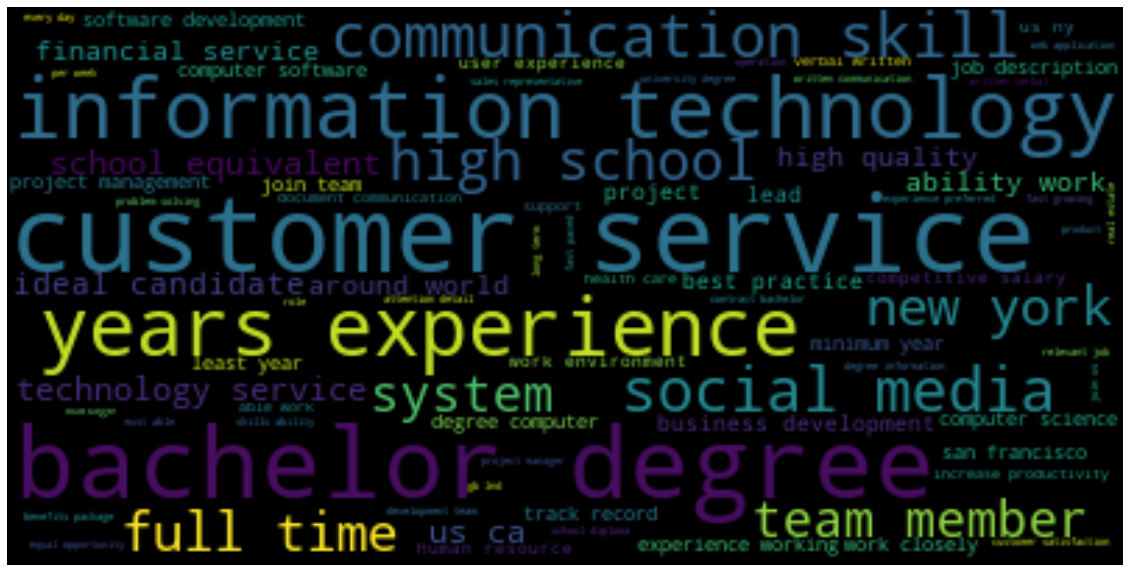

In [ ]:
#Visualizing Word Cloud 
#Real Jobs' Word Cloud
plt.figure(figsize = (20,20))
wc = WordCloud().generate(" ".join(text_df[text_df.fraudulent == 0].content))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

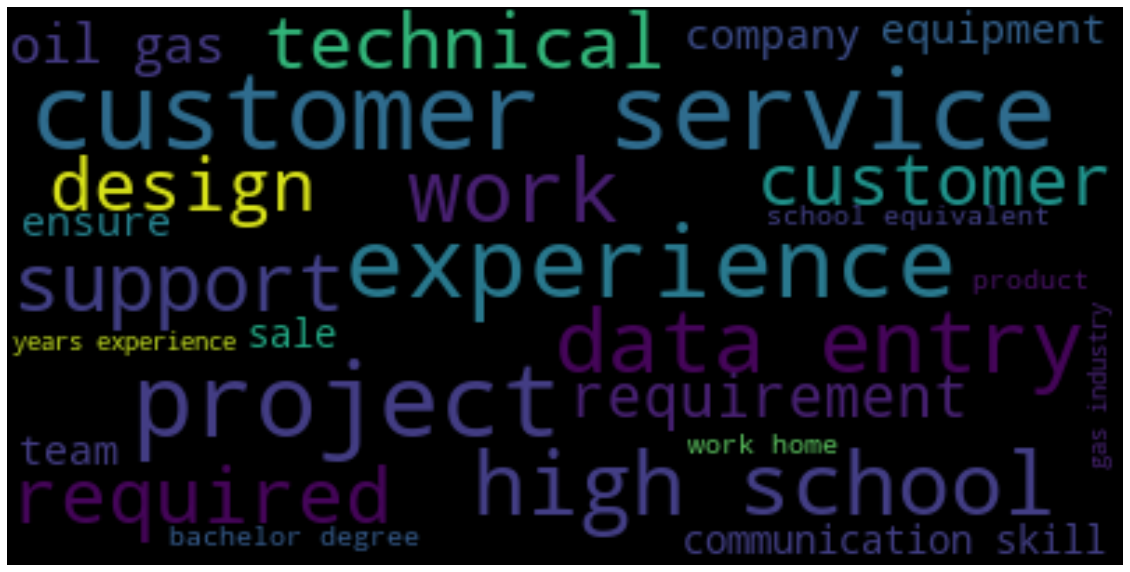

In [ ]:
#Fake Jobs' Word Cloud
plt.figure(figsize = (20,20))
wc = WordCloud(max_words=25).generate(" ".join(text_df[text_df.fraudulent == 1].content))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")

## **Data Cleaning: Vectorization and Balancing the Training Set**

In [7]:
#Vectorize feature space by counts of each word 
#Using Counter_vectorizer
y=text_df['fraudulent']
x=text_df['content']
v = CountVectorizer(analyzer = "word")
features = v.fit_transform(x)

#Splitting Training and Testing Set
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(features, y, test_size=0.3, random_state=100,stratify=y)

#Balancing only Training Dataset using Oversampling method 
from collections import Counter
# print(sorted(Counter(y).items()))
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled_c, y_resampled_c = ros.fit_resample(X_train_c, y_train_c)
print(sorted(Counter(y_resampled_c).items()))

[(0, 11910), (1, 11910)]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [8]:
#Vectorize feature space by TF-IDF score
#Using TF-IDF SCORE
y=text_df['fraudulent']
x=text_df['content']
v = TfidfVectorizer(analyzer = "word")
features = v.fit_transform(x)

#Splitting Training and Testing Set
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(features, y, test_size=0.3, random_state=100,stratify=y)

#Balancing only Training Dataset using Oversampling method 
from collections import Counter
# print(sorted(Counter(y).items()))
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled_t, y_resampled_t = ros.fit_resample(X_train_t, y_train_t)
print(sorted(Counter(y_resampled_t).items()))

[(0, 11910), (1, 11910)]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## **Logistic Regression**

In [9]:
#Logistic Regression
#Countvectorizer
lg_c = LogisticRegression(penalty='l2')
lg_c.fit(X_resampled_c,y_resampled_c)
print(f1_score(y_resampled_c, lg_c.predict(X_resampled_c),average='micro'))
y_pred_lg_c = lg_c.predict(X_test_c)
print(f1_score(y_test_c, y_pred_lg_c))#F1 score

0.9999580184718724
0.793233082706767


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [10]:
y_pred_lg_c = np.around(y_pred_lg_c, decimals = 0)
c_report=classification_report(y_test_c,y_pred_lg_c,target_names = ['0','1'])
print(c_report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5104
           1       0.78      0.81      0.79       260

    accuracy                           0.98      5364
   macro avg       0.88      0.90      0.89      5364
weighted avg       0.98      0.98      0.98      5364



In [11]:
#Logistic Regression with TF-IDF
lg_tf = LogisticRegression()
lg_tf.fit(X_resampled_t,y_resampled_t)
print(f1_score(y_resampled_t, lg_tf.predict(X_resampled_t)))
y_pred_lg_tf = lg_tf.predict(X_test_t)
print(f1_score(y_test_t, y_pred_lg_tf))#F1 score
t_report=classification_report(y_test_t,y_pred_lg_tf,target_names = ['0','1'])
print(t_report)

0.9961525593844095
0.8149466192170819
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5104
           1       0.76      0.88      0.81       260

    accuracy                           0.98      5364
   macro avg       0.88      0.93      0.90      5364
weighted avg       0.98      0.98      0.98      5364



## **Decision Tree**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from random import randint
from sklearn.tree import DecisionTreeClassifier
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [1,20,40,60,80,100,200, None],
              'min_samples_split':[2,3,4,5,6,7,8],
              "criterion": ["gini", "entropy"]
              }

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5,scoring = 'f1')

# Fit it to the data
tree_cv.fit(X_resampled_c,y_resampled_c)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'min_samples_split': 2, 'max_depth': None, 'criterion': 'entropy'}
Best score is 0.985928535357958


In [ ]:
print(f1_score(y_resampled_c, tree_cv.predict(X_resampled_c)))
y_pred_d_c = tree_cv.predict(X_test_c)
print(f1_score(y_test_c, y_pred_d_c))#F1 score

1.0
0.6112054329371817


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from random import randint
from sklearn.tree import DecisionTreeClassifier
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [1,20,40,60,80,100,200, None],
              'min_samples_split':[2,3,4,5,6,7,8],
              "criterion": ["gini", "entropy"]
              }

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5,scoring = 'f1')

# Fit it to the data
tree_cv.fit(X_resampled_t,y_resampled_t)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'min_samples_split': 5, 'max_depth': 100, 'criterion': 'entropy'}
Best score is 0.9863388409857041


In [ ]:
print(f1_score(y_resampled_c, tree_cv.predict(X_resampled_t)))
y_pred_d_t = tree_cv.predict(X_test_t)
print(f1_score(y_test_t, y_pred_d_t))#F1 score

1.0
0.6338259441707718


### **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 800, num = 5)]
min_samples_split = [2,3 , 4, 5]
min_samples_leaf = [1, 2]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth':[20, 30, 40, 50,100,200,300, None],
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 5,scoring = 'f1')
rf_random.fit(X_resampled_c, y_resampled_c)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
print("Average of the best f1-score in various folds during cross validation = ",rf_random.best_score_)
print("The best parameters found during k-fold cross validation is = ",rf_random.best_params_)

Average of the best f1-score in various folds during cross validation =  0.9988260835016227
The best parameters found during k-fold cross validation is =  {'n_estimators': 602, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 200}


In [ ]:
print(f1_score(y_resampled_c, rf_random.predict(X_resampled_c)))
y_pre=rf_random.predict(X_test_c)
print(f1_score(y_test_c, y_pre))#F1 score

1.0
0.7706422018348624


In [ ]:
#Random Forest With TF-IDF
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 800, num = 5)]
min_samples_split = [2,3 , 4, 5]
min_samples_leaf = [1, 2]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth':[20, 30, 40, 50,100,200,300, None],
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 5,scoring = 'f1')
rf_random.fit(X_resampled_t, y_resampled_t)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
print("Average of the best f1-score in various folds during cross validation = ",rf_random.best_score_)
print("The best parameters found during k-fold cross validation is = ",rf_random.best_params_)

Average of the best f1-score in various folds during cross validation =  0.9994546539641933
The best parameters found during k-fold cross validation is =  {'n_estimators': 602, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': None}


In [ ]:
print(f1_score(y_resampled_t, rf_random.predict(X_resampled_t)))
y_pre=rf_random.predict(X_test_t)
print(f1_score(y_test_t, y_pre))#F1 score

1.0
0.7500000000000001


## **LSTM**

In [12]:
## Creating model
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 100000
embedding_dim = 64
max_length = 250
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

#Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_df['content'].values)
# word = tokenizer.word_index
# print(len(word))
x = tokenizer.texts_to_sequences(text_df['content'].values) 
#Padding the dataset                       
x_pad = pad_sequences(x)   
y = df['fraudulent']                                                                
#print(Y.shape)

#spliting dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_pad,y, test_size = 0.30,random_state=100,stratify=y)

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

X_train = np.array(X_resampled)
y_train = np.array(y_resampled)
X_test = np.array(X_test)
y_test = np.array(y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [13]:
#Budding the Bidirectional-LSTM model 
import tensorflow_addons as tfa
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(100000, 50, input_length=1000),   #50 is good for embedding_dim(output dimension), 10000 vocabulary size
        tf.keras.layers.SpatialDropout1D(0.2),#randomly dropout 20 percent embedding layers to reduce overfitting
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100)),#Bidirectional model
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])#using cross entropy for loss function

In [15]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [EarlyStopping(monitor='val_loss', patience=2)]#Number of epochs with no improvement after which training will be stopped.
model.fit(X_train, y_train, epochs=10,batch_size=64, validation_split=0.2,callbacks=callbacks, verbose=1) #validation

Epoch 1/10
298/298 [==============================] - 850s 3s/step - loss: 0.0019 - accuracy: 0.9992 - val_loss: 7.4637e-04 - val_accuracy: 1.0000
Epoch 2/10
298/298 [==============================] - 842s 3s/step - loss: 0.0025 - accuracy: 0.9991 - val_loss: 2.9999e-04 - val_accuracy: 1.0000
Epoch 3/10
298/298 [==============================] - 842s 3s/step - loss: 0.0020 - accuracy: 0.9993 - val_loss: 0.0067 - val_accuracy: 0.9969
Epoch 4/10
298/298 [==============================] - 841s 3s/step - loss: 0.0015 - accuracy: 0.9993 - val_loss: 6.7813e-04 - val_accuracy: 1.0000


In [24]:
pre_x = model.predict(X_train)
pre_x = np.around(pre_x, decimals = 0)
print(f1_score(y_train, pre_x))#F1 score
y_pred_lstm = model.predict(X_test)

0.9995384163484536


In [25]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
y_pred_lstm = np.around(y_pred_lstm, decimals = 0)
print(f1_score(y_test, y_pred_lstm,average='binary'))#F1 score
c_report=classification_report(y_test,y_pred_lstm,target_names = ['0','1'])
print(c_report)

0.7715517241379309
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5104
           1       0.88      0.69      0.77       260

    accuracy                           0.98      5364
   macro avg       0.93      0.84      0.88      5364
weighted avg       0.98      0.98      0.98      5364



## **SVM**

In [ ]:
#SVC with countervectorizer
from sklearn.svm import SVC
svc = SVC(kernel = 'linear', gamma = 'auto')
svc.fit(X_resampled_c,y_resampled_c)
print(f1_score(y_resampled_c, svc.predict(X_resampled_c)))
y_pred_svc = svc.predict(X_test_c)
print(f1_score(y_test_c, y_pred_svc))#F1 score

1.0
0.782608695652174


In [ ]:
#SVC with TF-IDF
svc = SVC(kernel = 'linear', gamma = 'auto')
svc.fit(X_resampled_t,y_resampled_t)
print(f1_score(y_resampled_t, svc.predict(X_resampled_t)))
y_pred_svc = svc.predict(X_test_t)
print(f1_score(y_test_t, y_pred_svc))#F1 score

0.9996223089512779
0.8553971486761711
